### **Figure 3: Myeloarchitectonic similarity is associated with co-expression of genes in glutamatergic neurons and PV+ and VIP+ interneurons**

Cell type and cell subtype-specific correlated gene expression networks are provided in output/gene_exp/cge/

Coarse MIND network edges per subject are saved to output/subj_dfs/edge_per_subj_coarse.csv

If using these, 3.2 and 3.3 do not need to be run

#### **3.1 Setup**

In [1]:
# Autoreload
%load_ext autoreload
%autoreload 2

# Import helper functions
import sys
sys.path.append('code')
from stats_helpers import *
from MIND_helpers import *
from preprocessing_helpers import *
from plotting_helpers import *

#### **3.2 Generate correlated gene expression (CGE) networks**

CELLxGENE data from Krienen et al. (2023) can be downloaded at:
https://cellxgene.cziscience.com/collections/0fd39ad7-5d2d-41c2-bda0-c55bde614bdb

In [ ]:
# Import packages
import scanpy as sc

# Initialise directories
data_dir = "data/"
save_dir = "output/gene_exp/cge/"

# Dictionary holding cell type filenames
cell_types_dict = {
    'GAD': 'd48da0be-0e47-485f-a36b-f02643d1058d.h5ad',
    'oligo': 'c5e9c2f7-a450-409f-90d3-382f7109f5e1.h5ad',
    'astro': 'd6d9942f-491b-416b-8951-330309bbc654.h5ad',
    'glut': '5123a9c0-67e1-41da-9f59-f0894d62393a.h5ad',
    'endo': '7d4ce011-c8d5-472f-8256-e3d5551e13e9.h5ad',
    'immune': 'ac4323c8-c065-4d30-978b-ddb5537c36a2.h5ad'
}

# Dictionary holding coarse region names
# Keys = names given in CELLxGENE matrices
# Values = short names
regions = {
    "dorsolateral prefrontal cortex":'DLP',
    "ventrolateral prefrontal cortex":'VLP',
    "medial prefrontal cortex":'MPC',
    "orbitofrontal cortex":'OFC',
    "lateral temporal cortex":'LTC',
    "lateral parietal cortex":'LPC',
    "posterior cingulate area 23":'PCA',
    "primary motor cortex":'M1',
    "primary somatosensory cortex":'S1',
    "primary auditory cortex":'A1',
    "primary visual cortex":'V1',
    "secondary visual cortex":'V2'
}

# Loop cell types
for cell_type, cell_type_path in tqdm(cell_types_dict.items()):
    # Load CELLxGENE df
    adata = sc.read_h5ad(os.path.join(data_dir, cell_type_path))

    # Retain cortical regions of interest
    adata = adata[adata.obs['anatomical_name'].isin(list(regions.keys()))]

    # Retain top 10% most variable genes
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=int(adata.var.shape[0]*0.1))
    adata = adata[:, adata.var['highly_variable']]
            
    # Get list of genes for which expression was measured
    genes = adata.var['human_gene_name'].unique().tolist()

    # Initialse df to hold mean expression of each gene in each region
    region_gene_mat = np.zeros((len(regions), len(genes)))

    # Loop regions
    for idx_region, region in enumerate(list(regions.keys())):
        # Get region indices
        region_indices = np.where(adata.obs['anatomical_name'] == region)[0].tolist()
        region_data = adata.X[region_indices, :]
        
        # Get mean expression of all genes over all cells in this region
        if region_data.shape[0] > 0:
            region_gene_mat[idx_region, :] = region_data.mean(axis=0)

    # Cross-correlate regional expression vectors to get correlated gene expression matrix
    cge = pd.DataFrame(np.corrcoef(region_gene_mat), index=list(regions.values()), columns=list(regions.values()))

    # Save
    cge.to_csv(os.path.join(save_dir, f'{cell_type}_cge.csv'))

Visualise correlated gene expression networks

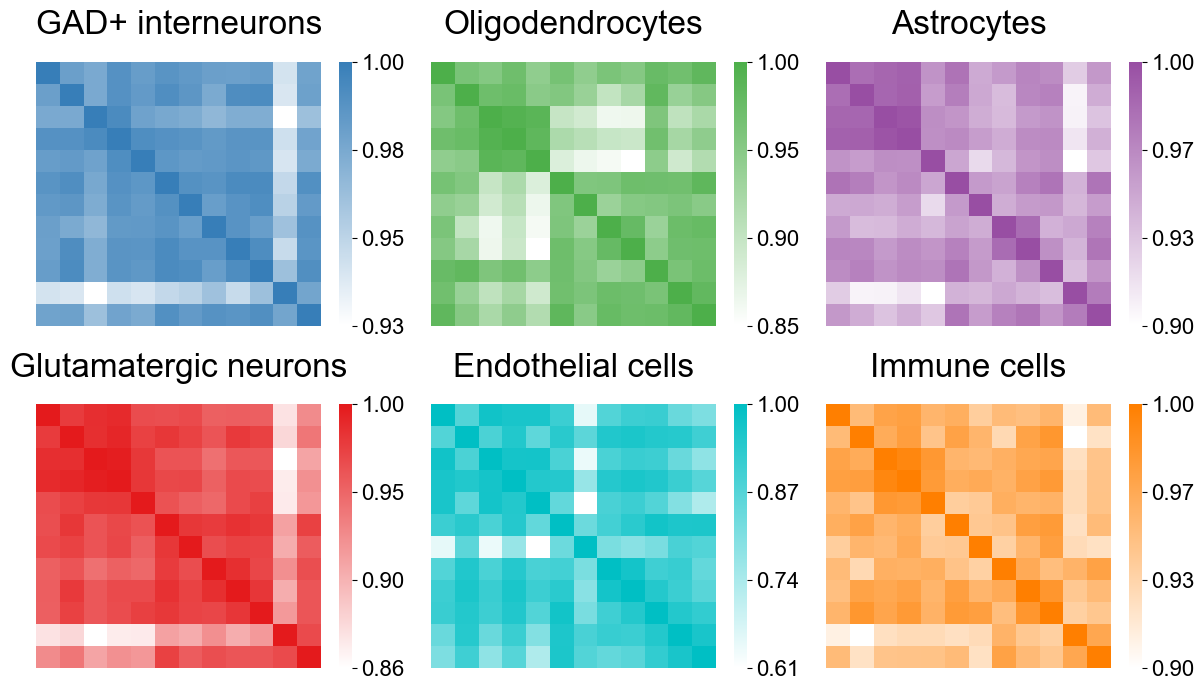

In [2]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import rcParams

# Set font to Arial
rcParams['font.family'] = 'Arial'

# Directory containing CGE matrices
cge_mat_dir = 'output/gene_exp/cge/'

# Dictionary holding cell type filenames
cell_dict = {
    'GAD': 'GAD_cge.csv',
    'oligo': 'oligo_cge.csv',
    'astro': 'astro_cge.csv',
    'glut': 'glut_cge.csv',
    'endo': 'endo_cge.csv',
    'immune': 'immune_cge.csv'
}

# Dictionary holding colour mapping for cell types
cmap = {
    'GAD': [55/255, 126/255, 184/255, 1],  
    'oligo': [77/255, 175/255, 74/255, 1],     
    'astro': [152/255, 78/255, 163/255, 1], 
    'glut': [228/255, 26/255, 28/255, 1],  
    'endo': [0/255, 191/255, 196/255, 1],
    'immune': [255/255, 127/255, 0/255, 1], 
}

# Dictionary holding full names for cell types
cell_names = {
    'GAD': 'GAD+ interneurons',  
    'oligo': 'Oligodendrocytes',     
    'astro': 'Astrocytes', 
    'glut': 'Glutamatergic neurons',  
    'endo': 'Endothelial cells',
    'immune': 'Immune cells', 
}

# Create subplots
n_cells = len(cell_dict)
fig, axes = plt.subplots(2, 3, figsize=(12, 7))  # Adjust grid size as needed
axes = axes.flatten()  # Flatten to easily iterate over

# Iterate over cell types and plot
for i, (cell, filename) in enumerate(cell_dict.items()):
    # Load CGE matrix
    cge_mat_path = os.path.join(cge_mat_dir, filename)
    cge_mat = pd.read_csv(cge_mat_path, index_col=0)

    # Set colourmap
    cmap_custom = LinearSegmentedColormap.from_list(f'{cell}_cmap', [[1, 1, 1, 1], cmap[cell]])

    # Plot
    ax = axes[i]
    sns.heatmap(cge_mat, cmap=cmap_custom, ax=ax, cbar=True, xticklabels=[], yticklabels=[], rasterized=True)
    ax.set_title(f'{cell_names[cell]}', fontsize=24, pad=20)

    # Adjust colour bar
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)
    min_val = np.nanmin(cge_mat.values)
    ticks = np.linspace(min_val, 1, 4)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{tick:.2f}' for tick in ticks], fontname='Arial')

plt.tight_layout()
plt.show()

Calculate correlated gene expression matrices for interneuron clusters defined in Krienen et al. (2023)

In [ ]:
# Import packages
import scanpy as sc

# Initialise directories
data_dir = "data/"
save_dir = "output/gene_exp/cge/"

# GAD CELLxGENE df path
GAD_path = os.path.join(data_dir, "d48da0be-0e47-485f-a36b-f02643d1058d.h5ad")

# Dictionary holding cell type filenames
regions = {
    "dorsolateral prefrontal cortex":'DLP',
    "ventrolateral prefrontal cortex":'VLP',
    "medial prefrontal cortex":'MPC',
    "orbitofrontal cortex":'OFC',
    "lateral temporal cortex":'LTC',
    "lateral parietal cortex":'LPC',
    "posterior cingulate area 23":'PCA',
    "primary motor cortex":'M1',
    "primary somatosensory cortex":'S1',
    "primary auditory cortex":'A1',
    "primary visual cortex":'V1',
    "secondary visual cortex":'V2'
}

# Load CELLxGENE df
adata = sc.read_h5ad(GAD_path)

# Retain cortical regions of interest
adata = adata[adata.obs['anatomical_name'].isin(list(regions.keys()))]

# Retain top 10% most variable genes
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=int(adata.var.shape[0]*0.1))
adata = adata[:, adata.var['highly_variable']]

# Get genes
genes = adata.var['human_gene_name'].unique().tolist()

# Get clusters
clusters = adata.obs["CLUSTER"].unique()

# Loop clusers
for cluster in tqdm(clusters):                    
    # Initialse df to hold mean expression of each gene in each region
    region_gene_mat = np.zeros((len(regions), len(genes)))
    
    # Loop regions, average across regions
    for idx_region, region in enumerate(regions.keys()):
        # Get indices of cells in the relevant region AND cluster
        region_cluster_idx = np.where((adata.obs["anatomical_name"] == region) & (adata.obs["CLUSTER"] == cluster))[0]
        region_cluster_data = adata.X[region_cluster_idx, :]
        
        # Get mean expression of all genes over all cells in this cluster in this region
        if region_cluster_data.shape[0] > 0: # Take mean
            region_gene_mat[idx_region, :] = region_cluster_data.mean(axis=0).A1 

    # Calculate CGE
    cge = np.corrcoef(region_gene_mat)

    # Save
    cge = pd.DataFrame(cge, index = regions.values(), columns = regions.values())
    cge.to_csv(os.path.join(save_dir, f'GAD_{cluster}_cge.csv'))

#### **3.3 Estimate individual coarse T1w/T2w similarity networks**

First, extract voxels from T1w/T2w images using `extract_voxels_coarse()`

In [ ]:
# Load region lookup table(s)
lut = pd.read_csv('data/lut_master.csv', index_col=0)
coarse_lut = pd.read_csv('data/coarse_lut.csv', index_col=0)

# Load subject lookup table
subj_df = pd.read_csv('data/subj_df_all.csv', index_col=0)

# Load relevant MRI directories
scan_dir = 'data/t12_img/'
label_dir = 'data/label_img/'

# Create dir to hold voxel values
vox_dir = 'output/T1wT2w/t12_MIND_coarse_all/'
os.makedirs(vox_dir, exist_ok=True)

# Loop subjects, extract voxels, save
for _, row in subj_df.iterrows():
    t12_img_path = os.path.join(scan_dir, f'T1wT2w_{row["id"].astype(int).astype(str).zfill(3)}.nii')
    label_img_path = os.path.join(label_dir, f'{row["id"].astype(int).astype(str).zfill(3)}_labels.nii')
    
    vox_coarse = extract_voxels_coarse(
        t12_img_path,
        label_img_path,
        lut, 'bm_code', 'Code',
        coarse_lut, 'ROIs_short', 'Side', 'Codes'
    )
    
    vox_coarse.to_csv(os.path.join(vox_dir, f'{row["id"].astype(int).astype(str).zfill(3)}_vox_coarse.csv'))

Now calculate MIND networks for each subject using `calculate_MIND_network()`

In [ ]:
# Import it to iterate subjects
import itertools as it

# Ignore division by 0 errors (these are normal) 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Create dir to hold MIND networks
MIND_dir = 'output/T1wT2w/t12_MIND_coarse_all/'
os.makedirs(MIND_dir, exist_ok=True)

# Get ROIs
labs = coarse_lut['Label'].unique()
n_rois = len(labs)

# Initialise df to hold edge values per subject
edge_per_subj_coarse = np.zeros((subj_df.shape[0], int((n_rois**2-n_rois)/2)))

# Loop subjects, calculate MIND network, save
for i, row in subj_df.iterrows():
    vox_path = os.path.join(vox_dir, f'{row["id"].astype(int).astype(str).zfill(3)}_vox_coarse.csv')
    vox_df = pd.read_csv(vox_path)

    MIND_net = calculate_mind_network(vox_df, ['Value'], labs)

    edge_per_subj_coarse[i,:] = MIND_net.values[np.triu_indices(n_rois, k=1)]

    MIND_path = os.path.join(MIND_dir, f'{row["id"].astype(int).astype(str).zfill(3)}_MIND_coarse.csv')
    MIND_net.to_csv(MIND_path)

# Save edge df
edge_per_subj_coarse_df = pd.concat([
    subj_df,
    pd.DataFrame(edge_per_subj_coarse, columns=list(it.combinations(labs,2)))
])
edge_per_subj_coarse_df.to_csv('output/subj_dfs/edge_per_subj_coarse.csv', index=False)

#### **3.4 Compute mean adult coarse T1w/T2w similarity network**

Remove outliers

Outliers are defined:
1. Automatically, by being in the top/bottom 1% of `global_t12` or `global_MIND`, i.e. mean T1w/T2w or degree across all regions
2. Manually, by identifying poorly registered scans

In [2]:
# Regional T1/2w
mean_t12_per_subj_df = pd.read_csv('output/subj_dfs/mean_t12_per_subj.csv', index_col=0)
mean_t12_per_subj_df = mean_t12_per_subj_df.sort_values('Age').reset_index(drop=True)

# Regional KNN MIND
degree_per_subj_df = pd.read_csv('output/subj_dfs/degree_per_subj.csv', index_col=0)
degree_per_subj_df = degree_per_subj_df.sort_values('Age').reset_index(drop=True)

# Edge KNN MIND
edge_per_subj_df = pd.read_csv('output/subj_dfs/edge_per_subj.csv', index_col=0)
edge_per_subj_df = edge_per_subj_df.sort_values('Age').reset_index(drop=True)

# Define global measures
global_t12 = mean_t12_per_subj_df.iloc[:,4:].mean(axis=1)
global_MIND = degree_per_subj_df.iloc[:,4:].mean(axis=1)

# Generate list of indices to remove
outlier_ind = mean_t12_per_subj_df.loc[
    (global_t12 < global_t12.quantile(0.01)) |
    (global_t12 > global_t12.quantile(0.99))
].index.tolist() + degree_per_subj_df.loc[
    (global_MIND < global_MIND.quantile(0.01)) |
    (global_MIND > global_MIND.quantile(0.99))
].index.tolist()

# Add manually identified outliers to the list
outlier_id = [425,128,412,410,292,358]
outlier_ind += [np.where(degree_per_subj_df['id'] == i)[0][0] for i in outlier_id]
outlier_ind = np.unique(outlier_ind).tolist()

# Filter 
edge_per_subj_coarse_df = pd.read_csv('output/subj_dfs/edge_per_subj_coarse.csv', index_col=0)
edge_per_subj_coarse_df_filt = edge_per_subj_coarse_df.drop(index=outlier_ind).reset_index(drop=True)


Calculate mean adult T1w/T2w and mean adult MIND network, using subjects > 1.75 years, save to `/output`

In [5]:
# Get ROIs
coarse_lut = pd.read_csv('data/coarse_lut.csv', index_col=0)
labs = coarse_lut['Label'].unique()

# Compute average MIND network
adult_edges = edge_per_subj_coarse_df_filt[edge_per_subj_coarse_df_filt['Age'] > 1.75].iloc[:,3:].mean(axis=0)
adult_MIND = np.zeros((len(labs), len(labs)))
adult_MIND[np.triu_indices(len(labs), k=1)] = adult_edges
adult_MIND += adult_MIND.T
np.fill_diagonal(adult_MIND, 1)
adult_MIND = pd.DataFrame(adult_MIND, index=labs, columns=labs)

# Save
save_dir = 'output/T1wT2w/mean/'
os.makedirs(save_dir, exist_ok=True)
adult_MIND.to_csv(os.path.join(save_dir, 'mean_adult_t12_MIND_coarse.csv'))

#### **3.5 Estimate coarse 4-year MBP expression similarity network**

First, extract voxels from MBP 4Y image using `extract_voxels_coarse()`

In [ ]:
# Load region lookup table(s)
lut = pd.read_csv('data/lut_master.csv', index_col=0)
coarse_lut = pd.read_csv('data/coarse_lut.csv', index_col=0)

# Initialise image paths
MBP_4Y_path = 'data/MBP_4Y_img.nii'
parc_img_path = 'data/sp2_label_512_v1.0.0.nii.gz'

# Extract voxels
vox_coarse = extract_voxels_coarse(
        MBP_4Y_path,
        parc_img_path,
        lut, 'bm_code', 'Code',
        coarse_lut, 'ROIs_short', 'Side', 'Codes'
    )

# Remove outlier values caused by slice artefacts
vox_coarse = vox_coarse[vox_coarse.Value < 0.8]

# Save
MBP_dir = 'output/MBP/'
os.makedirs(MBP_dir, exist_ok=True)
vox_coarse.to_csv(os.path.join(MBP_dir, 'MBP_4Y_vox_coarse.csv'))

Now calculate MIND network using `calculate_MIND_network()`

In [ ]:
# Ignore division by 0 errors (these are normal) 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Get ROIs
labs = coarse_lut['Label'].unique()
n_rois = len(labs)

# Load voxel values from coarse parcellation
vox_coarse = pd.read_csv('output/MBP/MBP_4Y_vox_coarse.csv', index_col=0)

# Calculate coarse MIND network
MBP_4Y_MIND_coarse = calculate_mind_network(vox_coarse, ['Value'], labs)

# Save
MBP_dir = 'output/MBP/'
os.makedirs(MBP_dir, exist_ok=True)
MBP_4Y_MIND_coarse.to_csv(os.path.join(MBP_dir, 'MBP_4Y_MIND_coarse.csv'))

#### **3.6 Correlate CGE and similarity network edges**

Start by loading data

In [52]:
# ----- Gene expression data ----- #
# Path to CGE matries
cge_mat_dir = 'output/gene_exp/cge/'

# Dictionary containing CGE matrix filenames
cell_dict = {
    'GAD': 'GAD_cge.csv',
    'oligo': 'oligo_cge.csv',
    'astro': 'astro_cge.csv',
    'glut': 'glut_cge.csv',
    'endo': 'endo_cge.csv',
    'immune': 'immune_cge.csv'
}

# Dictionary containing cell type colour mapping
cmap = {
    'GAD': [55/255, 126/255, 184/255, 1],  
    'oligo': [77/255, 175/255, 74/255, 1],     
    'astro': [152/255, 78/255, 163/255, 1], 
    'glut': [228/255, 26/255, 28/255, 1],  
    'endo': [0/255, 191/255, 196/255, 1],
    'immune': [255/255, 127/255, 0/255, 1], 
}

# ----- Anatomical data ----- #
# Lookup table
lut = pd.read_csv('data/lut_master.csv', index_col=0)

# Coarse lookup table
coarse_lut = pd.read_csv('data/coarse_lut.csv', index_col=0)

# Distance matrix
dist = pd.read_csv('data/distance_matrix.csv', index_col=0)
dist = dist.iloc[0:115,0:115].values

# Modality-specific anatomical data
anat = {
    'T12':{
        'mat':pd.read_csv('output/T1wT2w/mean/mean_adult_t12_MIND_coarse.csv', index_col=0), # Coarse matrix
        'mat_full':pd.read_csv('output/T1wT2w/mean/mean_adult_t12_MIND.csv', index_col=0), # Full matrix
        'map':pd.read_csv('output/T1wT2w/mean/mean_adult_regional_t12.csv', index_col=0), # Mean value map (full) 
        'surrogates_filename':'output/surrogates/mean_adult_t12_surrogates.csv' # Surrogate mean value maps (full)
    },
    'MBP':{
        'mat':pd.read_csv('output/MBP/MBP_4Y_MIND_coarse.csv', index_col=0), # Coarse matrix
        'mat_full':pd.read_csv('output/MBP/MBP_4Y_MIND.csv', index_col=0), # Full matrix
        'map':pd.read_csv('output/MBP/MBP_4Y_regional_mean.csv', index_col=0), # Mean value map (full) 
        'surrogates_filename': 'output/surrogates/MBP_4Y_regional_mean_surrogates.csv' # Surrogate mean value maps (full)
    }
}

Function to compute correlations and plot

In [53]:
def plot_cell_type_cge_MIND_correlations(modality, save_path=None):

    # Load anatomical data
    mat = anat[modality]['mat'].iloc[0:12,0:12] # Get lh
    mat_full = anat[modality]['mat_full'].iloc[0:115,0:115].values
    map = anat[modality]['map']; map = map[map.columns[0]].values[0:115]
    surrogates_filename = anat[modality]['surrogates_filename']

    # Make sure the MIND matrix is ordered correctly
    rois_ordered = ['DLP_L', 'VLP_L', 'MPC_L', 'OFC_L', 'LTC_L', 'LPC_L', 'PCA_L', 'M1_L', 'S1_L', 'A1_L', 'V1_L', 'V2_L']
    mat = mat.loc[rois_ordered,rois_ordered]

    # ----- Compute correlations ----- #

    # Initialise lists to hold r and p values
    cell_type_r_vals = []
    cell_type_p_vals = []

    # Iterate over cell types and plot
    for i, (cell, filename) in enumerate(cell_dict.items()):
        print(f"Calculating cell type: {cell}")
        cge_mat_path = os.path.join(cge_mat_dir, filename)
        cge_mat = pd.read_csv(cge_mat_path, index_col=0)

        # Make sure the matrix is ordered correctly
        rois_ordered = ['DLP', 'VLP', 'MPC', 'OFC', 'LTC', 'LPC', 'PCA', 'M1', 'S1', 'A1', 'V1', 'V2']
        cge_mat = cge_mat.loc[rois_ordered,rois_ordered]

        # Get r and p value
        r, p = get_brainsmashed_edge_correlation_p_val_coarse(mat_a = mat.values, 
                                                                mat_b = cge_mat.values, 
                                                                mat_a_full = mat_full,
                                                                map_a = map,
                                                                dist = dist,
                                                                coarse_lut = coarse_lut[coarse_lut['Side']=='L'], 
                                                                lut = lut[lut['Side']=='L'], 
                                                                surrogates_filename = surrogates_filename, 
                                                                n_perm = 1000, 
                                                                test_type = 'two-tailed')  
        
        cell_type_r_vals.append(r)
        cell_type_p_vals.append(p)


    # ----- Plotting ----- #

    # Sort cell types, colour map, r list, and p list to plot in descending order
    sorted_indices = np.argsort(cell_type_r_vals)
    sorted_cell_types = [list(cmap.keys())[i] for i in sorted_indices]
    sorted_colors = [list(cmap.values())[i] for i in sorted_indices]
    sorted_r_list = [cell_type_r_vals[i] for i in sorted_indices]
    sorted_p_list = [cell_type_p_vals[i] for i in sorted_indices]

    # Get corrected p-values (Bonferroni)
    _, p_corr, _, _ = multipletests(sorted_p_list, alpha=0.05, method='bonferroni')

    # Bar plot
    plt.figure(figsize=(4, 2.5))  # Adjust figure size for horizontal layout
    bars = plt.barh(sorted_cell_types, sorted_r_list, alpha=0.7, color=sorted_colors, height=0.9)
    plt.xlim([0,0.799])
    plt.title('All cell types', fontsize=20, pad=10, fontfamily='Arial')
    plt.yticks(fontsize=14, fontfamily='Arial')
    plt.xlabel('Spearman R', fontsize=20, fontfamily='Arial')
    plt.axvline(x=0, color='k')  # Baseline

    # Remove top and right spines
    ax=plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Annotate bars with asterisks based on p-values
    for bar, p_value in zip(bars, p_corr):
        if p_value < 0.001:
            annotation = '***'
        elif p_value < 0.01:
            annotation = '**'
        elif p_value < 0.05:
            annotation = '*'
        else:
            annotation = ''
        
        if annotation:  # Only annotate if there is an asterisk
            width = bar.get_width()
            y = bar.get_y() + bar.get_height() / 2
            plt.text(
                width + 0.02, y - 0.15,
                annotation,
                ha='left', va='center', fontsize=12, color='black', fontweight='bold'
            )

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()


    # ----- Build and display results table ----- #
    
    results_df = pd.DataFrame({
        "cell": sorted_cell_types,
        "r val": sorted_r_list,
        "p val": sorted_p_list,
        "p val corrected": p_corr
    })

    print(results_df)


Correlate T1w/T2w MIND with CGE

Calculating cell type: GAD
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 228.87it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:06<00:00, 166.53it/s]


Calculating cell type: oligo
Generating null matrices


100%|██████████| 1000/1000 [00:05<00:00, 193.73it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 170.26it/s]


Calculating cell type: astro
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 239.70it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 180.84it/s]


Calculating cell type: glut
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 243.29it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 182.70it/s]


Calculating cell type: endo
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 239.97it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 180.74it/s]


Calculating cell type: immune
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 229.54it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 182.59it/s]


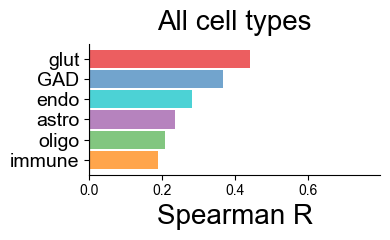

     cell     r val  p val  p val corrected
0  immune  0.189563  0.342            1.000
1   oligo  0.208392  0.211            1.000
2   astro  0.237032  0.246            1.000
3    endo  0.281870  0.091            0.546
4     GAD  0.366246  0.111            0.666
5    glut  0.441728  0.049            0.294


In [54]:
plot_cell_type_cge_MIND_correlations('T12', save_path=None)

Repeat for MBP expression MIND

Calculating cell type: GAD
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 233.87it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 180.35it/s]


Calculating cell type: oligo
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 243.10it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 179.19it/s]


Calculating cell type: astro
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 239.01it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 181.74it/s]


Calculating cell type: glut
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 236.70it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 174.04it/s]


Calculating cell type: endo
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 232.58it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 175.71it/s]


Calculating cell type: immune
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 222.84it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:06<00:00, 147.10it/s]


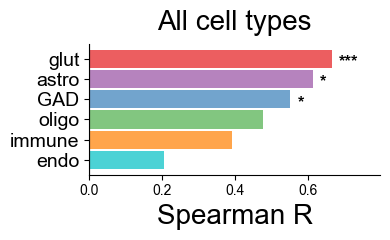

     cell     r val  p val  p val corrected
0    endo  0.205845  0.215            1.000
1  immune  0.393466  0.067            0.402
2   oligo  0.478802  0.018            0.108
3     GAD  0.552949  0.007            0.042
4   astro  0.614028  0.004            0.024
5    glut  0.666047  0.000            0.000


In [55]:
plot_cell_type_cge_MIND_correlations('MBP', save_path=None)

Plot scatterplot for correlation between MBP MIND and glutamatergic neuronal co-expression

Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 239.75it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 176.56it/s]


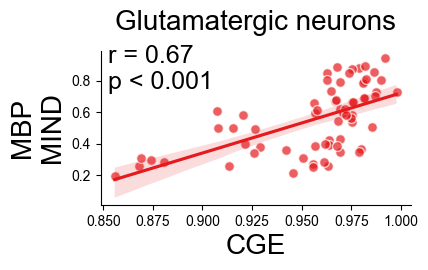

In [56]:
# Load anatomical data
modality = 'MBP'

mat = anat[modality]['mat'].iloc[0:12,0:12] # Get lh

# Make sure the matrix is ordered correctly
rois_ordered = ['DLP_L', 'VLP_L', 'MPC_L', 'OFC_L', 'LTC_L', 'LPC_L', 'PCA_L', 'M1_L', 'S1_L', 'A1_L', 'V1_L', 'V2_L']
mat = mat.loc[rois_ordered,rois_ordered]

mat_full = anat[modality]['mat_full'].iloc[0:115,0:115].values
map = anat[modality]['map']; map = map[map.columns[0]].values[0:115]
surrogates_filename = anat[modality]['surrogates_filename']

# Set path
cell = 'glut'
cge_mat = pd.read_csv(os.path.join(cge_mat_dir, cell_dict[cell]), index_col=0)

# Make sure the matrix is ordered correctly
rois_ordered = ['DLP', 'VLP', 'MPC', 'OFC', 'LTC', 'LPC', 'PCA', 'M1', 'S1', 'A1', 'V1', 'V2']
cge_mat = cge_mat.loc[rois_ordered,rois_ordered]

# Get r and p value
r, p = get_brainsmashed_edge_correlation_p_val_coarse(mat_a = mat.values, 
                                                      mat_b = cge_mat.values, 
                                                      mat_a_full = mat_full,
                                                      map_a = map,
                                                      dist = dist,
                                                      coarse_lut = coarse_lut[coarse_lut['Side']=='L'], 
                                                      lut = lut[lut['Side']=='L'], 
                                                      surrogates_filename = surrogates_filename, 
                                                      n_perm = 1000, 
                                                      test_type = 'two-tailed') 

# Scatter plot
coarse_triu_ind  = np.triu_indices_from(cge_mat, k=1)
cge_mat_triu = cge_mat.values[coarse_triu_ind]
mat_triu = mat.values[coarse_triu_ind]

plt.figure(figsize=(4,2))
sns.regplot(x=cge_mat_triu, y=mat_triu,
            scatter_kws={'alpha': 0.7, 'color': cmap[cell], 'edgecolors':'white', 's': 50},
            line_kws={'color': cmap[cell]})
ax=plt.gca()
if p < 0.001:
    p_text = 'p < 0.001'
else:
    p_text = f'p = {p:.3f}'
x1, x2 = ax.get_xlim(); y1, y2 = ax.get_ylim()
ax.text((x1 + 0.025*(x2-x1)), (y1 + 0.75*(y2-y1)), f'r = {r:.2f}\n{p_text}', fontsize=18, fontfamily='Arial')
ax.set_xlabel('CGE', fontsize=20, fontfamily='Arial')
ax.set_ylabel('MBP\nMIND', fontsize=20, fontfamily='Arial')
ax.set_title('Glutamatergic neurons', fontsize=20, pad=15, fontfamily='Arial')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()


Repeat for interneuron correlated gene expression matrices

Function to compute correlations and plot

In [57]:
def plot_cell_subtype_cge_MIND_correlations(modality, save_path=None):

    # Load anatomical data
    mat = anat[modality]['mat'].iloc[0:12,0:12] # Get lh
    mat_full = anat[modality]['mat_full'].iloc[0:115,0:115].values
    map = anat[modality]['map']; map = map[map.columns[0]].values[0:115]
    surrogates_filename = anat[modality]['surrogates_filename']

    # Make sure the MIND matrix is ordered correctly
    rois_ordered = ['DLP_L', 'VLP_L', 'MPC_L', 'OFC_L', 'LTC_L', 'LPC_L', 'PCA_L', 'M1_L', 'S1_L', 'A1_L', 'V1_L', 'V2_L']
    mat = mat.loc[rois_ordered,rois_ordered]

    # Dictionary storing interneuron subtypes
    subtype_cge_dict = {
        'GAD': range(1, 13)
    }

    # ----- Compute correlations ----- #

    # Initialise df to hold results
    results = []

    # Loop clusters
    for cell, clusters in subtype_cge_dict.items():
        for cluster in clusters:
            print(f"Calculating cell type cluster: {cell}_{cluster}")
            
            # Load cell subtype CGE matrix
            file_path = os.path.join(cge_mat_dir, f'{cell}_{cluster}_cge.csv')
            if not os.path.exists(file_path):
                continue
            cge_mat = pd.read_csv(file_path, index_col=0)

            # Make sure rois are in the correct order
            rois_ordered = ['DLP', 'VLP', 'MPC', 'OFC', 'LTC', 'LPC', 'PCA', 'M1', 'S1', 'A1', 'V1', 'V2']
            cge_mat = cge_mat.loc[rois_ordered,rois_ordered]

            # Skip subtype if does not contain data from all cell types
            if cge_mat.isna().any().any():
                print(f'{cell}_{cluster} contains nans: skipping...')
            else:
                # Get r and p value
                r, p = get_brainsmashed_edge_correlation_p_val_coarse(mat_a = mat.values, 
                                                                      mat_b = cge_mat.values, 
                                                                      mat_a_full = mat_full,
                                                                      map_a = map,
                                                                      dist = dist,
                                                                      coarse_lut = coarse_lut[coarse_lut['Side']=='L'], 
                                                                      lut = lut[lut['Side']=='L'], 
                                                                      surrogates_filename = surrogates_filename, 
                                                                      n_perm = 1000, 
                                                                      test_type = 'two-tailed')    
                results.append({
                    'cell_type': cell,
                    'cluster': cluster,
                    'r': r,
                    'p': p,
                })

    # Multiple comparisons correction
    raw_p_vals = [res['p'] for res in results]
    valid_idx = [i for i, p in enumerate(raw_p_vals) if not np.isnan(p)]
    valid_p_vals = [raw_p_vals[i] for i in valid_idx]

    _, p_corr, _, _ = multipletests(valid_p_vals, alpha=0.05, method='Bonferroni')
    for i, p_val in zip(valid_idx, p_corr):
        results[i]['p_corr'] = p_val
    for i in range(len(results)):
        if 'p_corr' not in results[i]:
            results[i]['p_corr'] = np.nan

    results_df = pd.DataFrame(results)


    # ----- Plotting ----- #

    # Mapping between clusters and neuronal subtypes (determined in Supplementary Figure 8)
    cluster_to_subtype_mapping = {
        '1':'LAMP5+ 1',
        '2':'LAMP5+ 2',
        '3':'VIP+',
        '4':'SNCG+ 1',
        '5':'SNCG+ 2',
        '6':'MEIS2+',
        '7':'SST+ 1',
        '8':'PV+ 1',
        '9':'PV+ 2',
        '10':'SST+ CHODL+',
        '11':'SST+ 2',
        '12':'SST+ 3',
    }

    # Map clusers to subtypes
    results_df['subtype'] = results_df['cluster'].astype(str).map(cluster_to_subtype_mapping)

    # Sort results
    results_df = results_df.sort_values(by=['r'], ascending=[False])

    # Bar plot
    g = sns.catplot(
        data=results_df, kind="bar", x="r", y="subtype", color=[55/255, 126/255, 184/255, 1],
        errorbar=None, alpha=0.7, height=3, aspect=2
    )
    g.set_axis_labels("Spearman R", "", fontsize=20, fontfamily='Arial')
    g.ax.set_yticklabels(g.ax.get_yticklabels(), ha='right', fontsize=14, fontfamily='Arial')
    g.ax.set_xlim([0, 0.7])
    ax = g.ax

    # Annotate significance
    for bar, (_, row) in zip(ax.patches, results_df.iterrows()):
        p = row['p_corr']
        if p < 0.001:
            txt = '***'
        elif p < 0.01:
            txt = '**'
        elif p < 0.05:
            txt = '*'
        else:
            txt = ''
        
        width = bar.get_width()
        y = bar.get_y() + bar.get_height() / 2
        ax.text(width + 0.01, y + 0.1, txt, ha='left', va='center', fontsize=14, fontweight='bold')

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

    # ----- Display results table ----- #

    print(results_df)

Correlate T1w/T2w MIND with subtype CGE

Calculating cell type cluster: GAD_1
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 239.08it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 174.21it/s]


Calculating cell type cluster: GAD_2
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 242.19it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 176.62it/s]


Calculating cell type cluster: GAD_3
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 228.79it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 180.18it/s]


Calculating cell type cluster: GAD_4
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 248.75it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 187.41it/s]


Calculating cell type cluster: GAD_5
GAD_5 contains nans: skipping...
Calculating cell type cluster: GAD_6
GAD_6 contains nans: skipping...
Calculating cell type cluster: GAD_7
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 249.62it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 186.14it/s]


Calculating cell type cluster: GAD_8
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 235.29it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 181.33it/s]


Calculating cell type cluster: GAD_9
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 244.07it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 178.82it/s]


Calculating cell type cluster: GAD_10
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 244.77it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 182.40it/s]


Calculating cell type cluster: GAD_11
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 244.77it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 181.38it/s]


Calculating cell type cluster: GAD_12
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 243.99it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 181.13it/s]
/var/folders/_0/khf_d2y950q8x7b5c90znmhw0000gn/T/ipykernel_41748/2522993120.py:105: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_yticklabels(g.ax.get_yticklabels(), ha='right', fontsize=14, fontfamily='Arial')


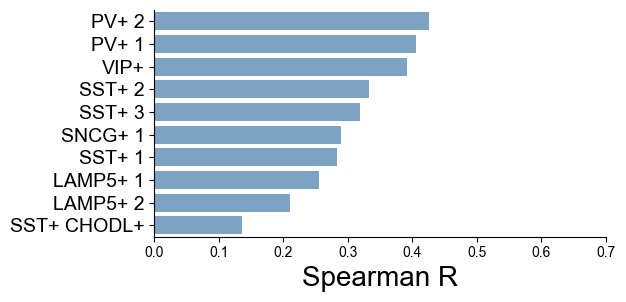

  cell_type  cluster         r      p  p_corr      subtype
6       GAD        9  0.425112  0.049    0.49        PV+ 2
5       GAD        8  0.404906  0.085    0.85        PV+ 1
2       GAD        3  0.390836  0.061    0.61         VIP+
8       GAD       11  0.332721  0.172    1.00       SST+ 2
9       GAD       12  0.318192  0.210    1.00       SST+ 3
3       GAD        4  0.288843  0.183    1.00      SNCG+ 1
4       GAD        7  0.282831  0.250    1.00       SST+ 1
0       GAD        1  0.255067  0.270    1.00     LAMP5+ 1
1       GAD        2  0.209477  0.362    1.00     LAMP5+ 2
7       GAD       10  0.135456  0.573    1.00  SST+ CHODL+


In [58]:
plot_cell_subtype_cge_MIND_correlations('T12', save_path=None)

Repeat for MBP expression MIND

Calculating cell type cluster: GAD_1
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 237.04it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 179.38it/s]


Calculating cell type cluster: GAD_2
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 236.25it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 183.16it/s]


Calculating cell type cluster: GAD_3
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 238.37it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 186.22it/s]


Calculating cell type cluster: GAD_4
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 244.59it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 186.98it/s]


Calculating cell type cluster: GAD_5
GAD_5 contains nans: skipping...
Calculating cell type cluster: GAD_6
GAD_6 contains nans: skipping...
Calculating cell type cluster: GAD_7
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 237.48it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 181.52it/s]


Calculating cell type cluster: GAD_8
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 234.85it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 183.85it/s]


Calculating cell type cluster: GAD_9
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 245.65it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 184.48it/s]


Calculating cell type cluster: GAD_10
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 241.15it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 171.34it/s]


Calculating cell type cluster: GAD_11
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 239.19it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 175.74it/s]


Calculating cell type cluster: GAD_12
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 245.37it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:05<00:00, 187.39it/s]
/var/folders/_0/khf_d2y950q8x7b5c90znmhw0000gn/T/ipykernel_41748/2522993120.py:105: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_yticklabels(g.ax.get_yticklabels(), ha='right', fontsize=14, fontfamily='Arial')


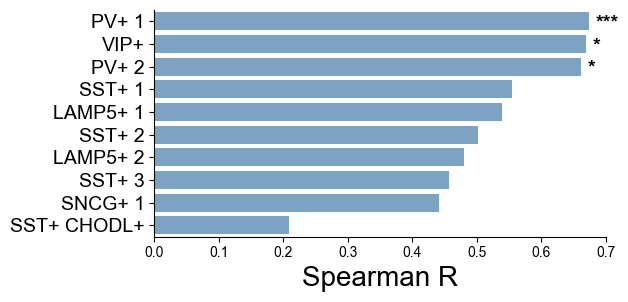

  cell_type  cluster         r      p  p_corr      subtype
5       GAD        8  0.673896  0.000    0.00        PV+ 1
2       GAD        3  0.669680  0.003    0.03         VIP+
6       GAD        9  0.661330  0.001    0.01        PV+ 2
4       GAD        7  0.553575  0.013    0.13       SST+ 1
0       GAD        1  0.538169  0.014    0.14     LAMP5+ 1
8       GAD       11  0.500887  0.025    0.25       SST+ 2
1       GAD        2  0.480263  0.032    0.32     LAMP5+ 2
9       GAD       12  0.456424  0.041    0.41       SST+ 3
3       GAD        4  0.440476  0.036    0.36      SNCG+ 1
7       GAD       10  0.207932  0.358    1.00  SST+ CHODL+


In [59]:
plot_cell_subtype_cge_MIND_correlations('MBP', save_path=None)